In [126]:
import sys
sys.path.append(r'/Users/brendanliang/Code/brendans_bloomberg') 
import numpy as np
import pandas as pd
import math
import os
import subprocess
import shlex
import matplotlib.pyplot as plt
from datetime import datetime
from tools.helper.pandas_tools import find_col_index
from interface.company import Company
from interface.indicator import Yahoo_Indicator
from interface.forex import forex

In [127]:
company = Company("AAPl")

# Share Price History

[datetime.date(2013, 4, 17)]
[8157] [21419]


/var/folders/wq/cty68g4x0mv13xchkmnt7md00000gn/T/ipykernel_13080/4175563673.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(company.price_history.dates, company.price_history.close/float(company.price_history.close[company_index]))
/var/folders/wq/cty68g4x0mv13xchkmnt7md00000gn/T/ipykernel_13080/4175563673.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(Yahoo_Indicator("^GSPC").dates, Yahoo_Indicator("^GSPC").close/float(Yahoo_Indicator("^GSPC").close[benchmark_index_index]))


(15812.0, 19755.0)

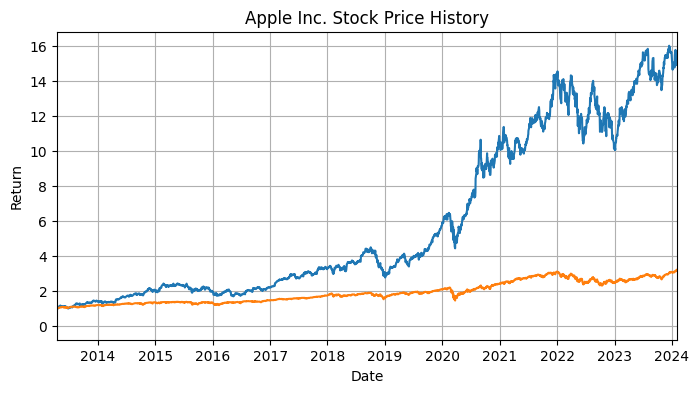

In [128]:
recency_bias = 0.25
proportion = 1 - recency_bias
start_date = company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)]
print(start_date)
company_index = np.where(company.price_history.dates == start_date)[0]
benchmark_index_index = np.where(Yahoo_Indicator("^GSPC").dates == start_date)[0]
plt.figure(figsize=(8, 4))  # Customize the figure size if needed
plt.plot(company.price_history.dates, company.price_history.close/float(company.price_history.close[company_index]))
plt.plot(Yahoo_Indicator("^GSPC").dates, Yahoo_Indicator("^GSPC").close/float(Yahoo_Indicator("^GSPC").close[benchmark_index_index]))
plt.xlabel("Date")
plt.ylabel("Return")
plt.title(f"{company.profile.name} Stock Price History")
plt.grid(True)
plt.xlim(start_date[0], company.price_history.dates[-1][0])

# Financial Performance

## Income Statement

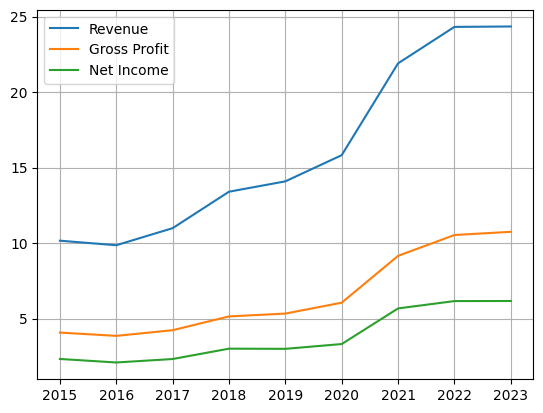

In [129]:
n = math.floor((1-proportion)*len(company.annual_income_statement.income_statement))
fig, ax = plt.subplots()
year, revenue, gross_profit, net_income, shs_out = [], [], [], [], []
for i in range(n):
    year.append(company.annual_income_statement.income_statement[i]['calendarYear'])
    revenue.append(company.annual_income_statement.income_statement[i]['revenue'])
    gross_profit.append(company.annual_income_statement.income_statement[i]['grossProfit'])
    net_income.append(company.annual_income_statement.income_statement[i]['netIncome'])
    shs_out.append(company.annual_income_statement.income_statement[i]['weightedAverageShsOut'])
    
ax.plot(year, np.array(revenue)/np.array(shs_out), label = "Revenue")
ax.plot(year, np.array(gross_profit)/np.array(shs_out), label = "Gross Profit")
ax.plot(year, np.array(net_income)/np.array(shs_out), label = "Net Income")
ax.grid()
ax.legend()
plt.show()

## Cash Flows

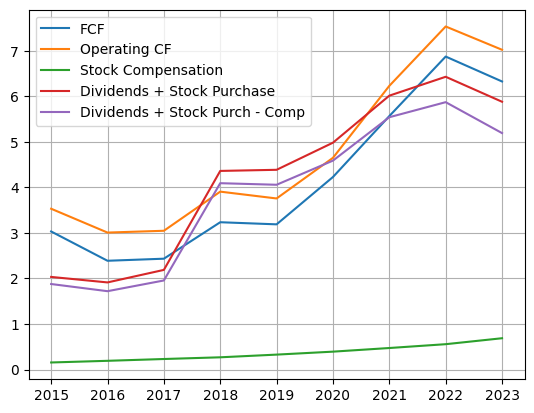

In [130]:
fig, ax = plt.subplots()
year, fcf, operating_cf, stock_comp, stock_repurchase, dividends = [], [], [], [], [], []
for i in range(n):
    year.append(company.annual_cashflow.cashflow[i]['calendarYear'])
    stock_comp.append(company.annual_cashflow.cashflow[i]['stockBasedCompensation'])
    stock_repurchase.append(company.annual_cashflow.cashflow[i]['commonStockRepurchased'])
    dividends.append(company.annual_cashflow.cashflow[i]['dividendsPaid'])
    operating_cf.append(company.annual_cashflow.cashflow[i]['operatingCashFlow'])
    fcf.append(company.annual_cashflow.cashflow[i]['freeCashFlow'])
    
ax.plot(year, np.array(fcf)/np.array(shs_out), label = "FCF")
ax.plot(year, np.array(operating_cf)/np.array(shs_out), label = "Operating CF")
ax.plot(year, np.array(stock_comp)/np.array(shs_out), label = "Stock Compensation")
ax.plot(year, (-np.array(dividends)-np.array(stock_repurchase))/np.array(shs_out), label = "Dividends + Stock Purchase")
ax.plot(year, (-np.array(stock_comp)-np.array(dividends)-np.array(stock_repurchase))/np.array(shs_out), label = "Dividends + Stock Purch - Comp")
ax.grid()
ax.legend()
plt.show()

## Balance Sheet

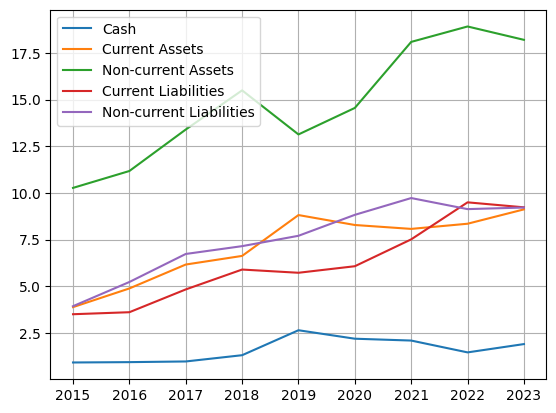

In [131]:
fig, ax = plt.subplots()
year, cashAndCashEquivalents, totalCurrentAssets, totalNonCurrenAssets, totalCurrentLiabilities, totalNonCurrentLiabilities = [], [], [], [], [], []
for i in range(n):
    year.append(company.annual_balance_sheet.balance_sheet[i]['calendarYear'])
    cashAndCashEquivalents.append(company.annual_balance_sheet.balance_sheet[i]['cashAndCashEquivalents'])
    totalCurrentAssets.append(company.annual_balance_sheet.balance_sheet[i]['totalCurrentAssets'])
    totalNonCurrenAssets.append(company.annual_balance_sheet.balance_sheet[i]['totalNonCurrentAssets'])
    totalCurrentLiabilities.append(company.annual_balance_sheet.balance_sheet[i]['totalCurrentLiabilities'])
    totalNonCurrentLiabilities.append(company.annual_balance_sheet.balance_sheet[i]['totalNonCurrentLiabilities'])
    
ax.plot(year, np.array(cashAndCashEquivalents)/np.array(shs_out), label = "Cash")
ax.plot(year, np.array(totalCurrentAssets)/np.array(shs_out), label = "Current Assets")
ax.plot(year, (np.array(totalNonCurrenAssets)-np.array(stock_repurchase))/np.array(shs_out), label = "Non-current Assets")
ax.plot(year, (np.array(totalCurrentLiabilities))/np.array(shs_out), label = "Current Liabilities")
ax.plot(year, (np.array(totalNonCurrentLiabilities))/np.array(shs_out), label = "Non-current Liabilities")
ax.grid()
ax.legend()
plt.show()

# Historical Valuations

/var/folders/wq/cty68g4x0mv13xchkmnt7md00000gn/T/ipykernel_13080/3685315091.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 100)


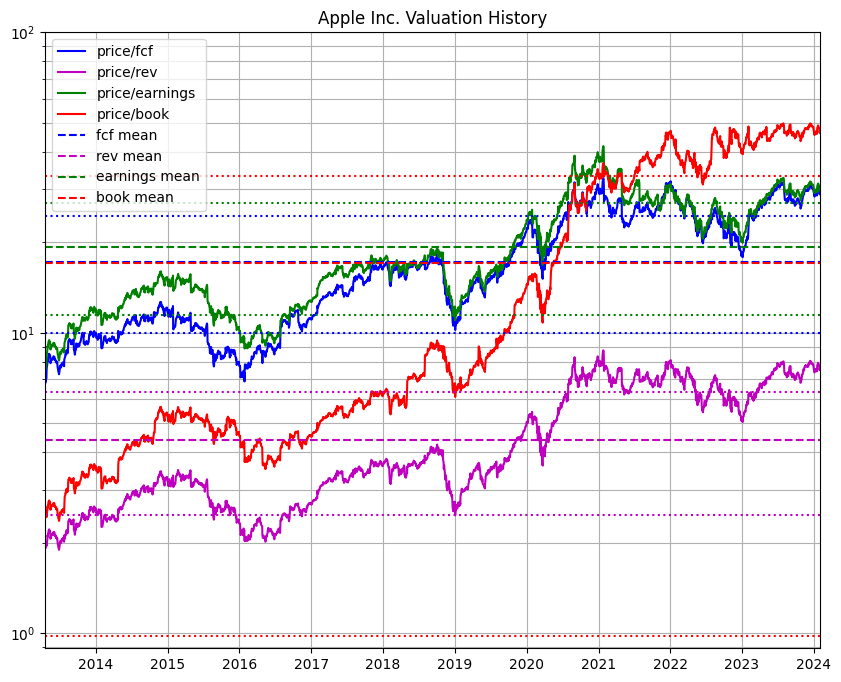

In [132]:
from tools.ttm_calculator import trailing_twelve_month
from datetime import datetime
ttm_cashflow = trailing_twelve_month(company.symbol, "cashflow_statement")
ttm_balance_sheet = trailing_twelve_month(company.symbol, "balance_sheet")
ttm_income_statement = trailing_twelve_month(company.symbol, "income_statement")
dates = []
price_fcf = []
price_rev = []
price_earnings = []
price_book = []

for i in range(len(company.price_history.close)):
    date = company.price_history.dates[i]
    price = company.price_history.close[i]
    dates.append(date)
    for j in range(len(ttm_cashflow)-1):
        if date > ttm_cashflow[0]["fillingDate"]:
            index = 0
            break
        if  date < ttm_cashflow[j]["fillingDate"] and date > ttm_cashflow[j+1]["fillingDate"]:
            index  = j + 1
            break
        if date < ttm_cashflow[-1]["fillingDate"]:
            index = -1
            break
    price_fcf.append(price / (ttm_cashflow[index]["freeCashFlow"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_rev.append(price / (ttm_income_statement[index]["revenue"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_earnings.append(price / (ttm_income_statement[index]["netIncome"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_book.append(price / ((ttm_balance_sheet[index]["totalAssets"] - ttm_balance_sheet[index]["totalLiabilities"]) / ttm_income_statement[index]["weightedAverageShsOut"]))

fig, ax = plt.subplots(figsize=(10, 8))
plt.yscale('log')
plt.ylim(0, 100)
plt.title(f"{company.profile.name} Valuation History")
plt.xlim(company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0], company.price_history.dates[-1][0])
ax.plot(dates, price_fcf, label= "price/fcf", color = "b")
ax.plot(dates, price_rev, label= "price/rev", color = "m")
ax.plot(dates, price_earnings, label= "price/earnings", color = "green")
ax.plot(dates, price_book, label= "price/book", color = "red")
ax.hlines(np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])), 
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="b", linestyles="--", label = "fcf mean")
ax.hlines(np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="b", linestyles="dotted")
ax.hlines(np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="b", linestyles="dotted")

ax.hlines(np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="m", linestyles="--", label = "rev mean")
ax.hlines(np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="m", linestyles="dotted")
ax.hlines(np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="m", linestyles="dotted")

ax.hlines(np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
              company.price_history.dates[-1][0], colors="green", linestyles="--", label = "earnings mean")
ax.hlines(np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="green", linestyles="dotted")
ax.hlines(np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="green", linestyles="dotted")

ax.hlines(np.mean(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="red", linestyles="--", label = "book mean")
ax.hlines(np.mean(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])) + np.std(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="red", linestyles="dotted")
ax.hlines(np.mean(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])) - np.std(np.array(price_book[math.floor(len(company.price_history.dates) * proportion):])),
          company.price_history.dates[math.floor(len(company.price_history.dates) * proportion)][0],
          company.price_history.dates[-1][0], colors="red", linestyles="dotted")
ax.grid(which="both")
ax.legend(loc = "upper left")

## Simple Monte Carlo DCF Forecasting and Valuation

In [133]:
from tools.wacc import wacc
from datetime import timedelta
interations = 1000
forecast_years = 3
discount_rate = wacc(company.symbol)
print(f"Discount Rate = {discount_rate}")
shares_rate = []
for i in range(math.floor(len(ttm_income_statement) * recency_bias)):
    shares_rate.append(ttm_income_statement[i]["weightedAverageShsOut"] / ttm_income_statement[i+ 1]["weightedAverageShsOut"] - 1)
shares_rate_mean, shares_rate_std = np.mean(shares_rate), np.std(shares_rate)

Discount Rate = 0.06497257539069497


### FCF Valuation

In [134]:
fcf_rate = []
for i in range(math.floor(len(ttm_cashflow) * recency_bias)):
    fcf_rate.append(ttm_cashflow[i]["freeCashFlow"] / ttm_cashflow[i+ 1]["freeCashFlow"] - 1)
fcf_rate_mean, fcf_rate_std = np.mean(fcf_rate), np.std(fcf_rate)
fcf_valuation_mean = np.mean(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):]))
fcf_valuation_std = np.std(np.array(price_fcf[math.floor(len(company.price_history.dates) * proportion):]))
fcf_fair_value = []
year = []
for i in range(forecast_years):
    current_year_value = []
    for j in range(interations):
        fcf_valuation_scalar = np.random.normal(fcf_valuation_mean, fcf_valuation_std)
        fcf_rate_scalar = np.random.normal(fcf_rate_mean, fcf_rate_std)
        num_shares_scalar = np.random.normal(shares_rate_mean, shares_rate_std)
        intermediate = fcf_valuation_scalar * ttm_cashflow[0]["freeCashFlow"] * (1 + fcf_rate_scalar) ** (i+1)
        num_shares = ttm_income_statement[0]["weightedAverageShsOut"] * (1 + num_shares_scalar) ** (i+1) 
        current_year_value.append(intermediate / num_shares)
    fcf_fair_value.append(current_year_value)

fcf_mean_price, fcf_std_price, year = [], [], []
for i, forecast in enumerate(fcf_fair_value):
    year.append(ttm_cashflow[0]["fillingDate"] + timedelta(days = 365*(i+1)))
    fcf_mean_price.append(np.mean(forecast))
    fcf_std_price.append(np.std(forecast))

### Revenue Valuation

In [135]:
rev_rate = []
for i in range(math.floor(len(ttm_income_statement) * recency_bias)):
    rev_rate.append(ttm_income_statement[i]["revenue"] / ttm_income_statement[i+ 1]["revenue"] - 1)
rev_rate_mean, rev_rate_std = np.mean(rev_rate), np.std(rev_rate)
rev_valuation_mean = np.mean(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):]))
rev_valuation_std = np.std(np.array(price_rev[math.floor(len(company.price_history.dates) * proportion):]))
rev_fair_value = []
year = []
for i in range(forecast_years):
    current_year_value = []
    for j in range(interations):
        rev_valuation_scalar = np.random.normal(rev_valuation_mean, rev_valuation_std)
        rev_rate_scalar = np.random.normal(rev_rate_mean, rev_rate_std)
        num_shares_scalar = np.random.normal(shares_rate_mean, shares_rate_std)
        intermediate = rev_valuation_scalar * ttm_income_statement[0]["revenue"] * (1 + rev_rate_scalar) ** (i+1)
        num_shares = ttm_income_statement[0]["weightedAverageShsOut"] * (1 + num_shares_scalar) ** (i+1) 
        current_year_value.append(intermediate / num_shares)
    rev_fair_value.append(current_year_value)

rev_mean_price, rev_std_price, year = [], [], []
for i, forecast in enumerate(rev_fair_value):
    year.append(ttm_cashflow[0]["fillingDate"] + timedelta(days = 365*(i+1)))
    rev_mean_price.append(np.mean(forecast))
    rev_std_price.append(np.std(forecast))

### Earnings Valuation

In [136]:
earnings_rate = []
for i in range(math.floor(len(ttm_income_statement) * recency_bias)):
    earnings_rate.append(ttm_income_statement[i]["netIncome"] / ttm_income_statement[i+ 1]["netIncome"] - 1)
earnings_rate_mean, earnings_rate_std = np.mean(earnings_rate), np.std(earnings_rate)
earnings_valuation_mean = np.mean(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):]))
earnings_valuation_std = np.std(np.array(price_earnings[math.floor(len(company.price_history.dates) * proportion):]))
earnings_fair_value = []
year = []
for i in range(forecast_years):
    current_year_value = []
    for j in range(interations):
        earnings_valuation_scalar = np.random.normal(earnings_valuation_mean, earnings_valuation_std)
        earnings_rate_scalar = np.random.normal(earnings_rate_mean, earnings_rate_std)
        num_shares_scalar = np.random.normal(shares_rate_mean, shares_rate_std)
        intermediate = earnings_valuation_scalar * ttm_income_statement[0]["netIncome"] * (1 + earnings_rate_scalar) ** (i+1)
        num_shares = ttm_income_statement[0]["weightedAverageShsOut"] * (1 + num_shares_scalar) ** (i+1) 
        current_year_value.append(intermediate / num_shares)
    earnings_fair_value.append(current_year_value)

earnings_mean_price, earnings_std_price, year = [], [], []
for i, forecast in enumerate(earnings_fair_value):
    year.append(ttm_cashflow[0]["fillingDate"] + timedelta(days = 365*(i+1)))
    earnings_mean_price.append(np.mean(forecast))
    earnings_std_price.append(np.std(forecast))


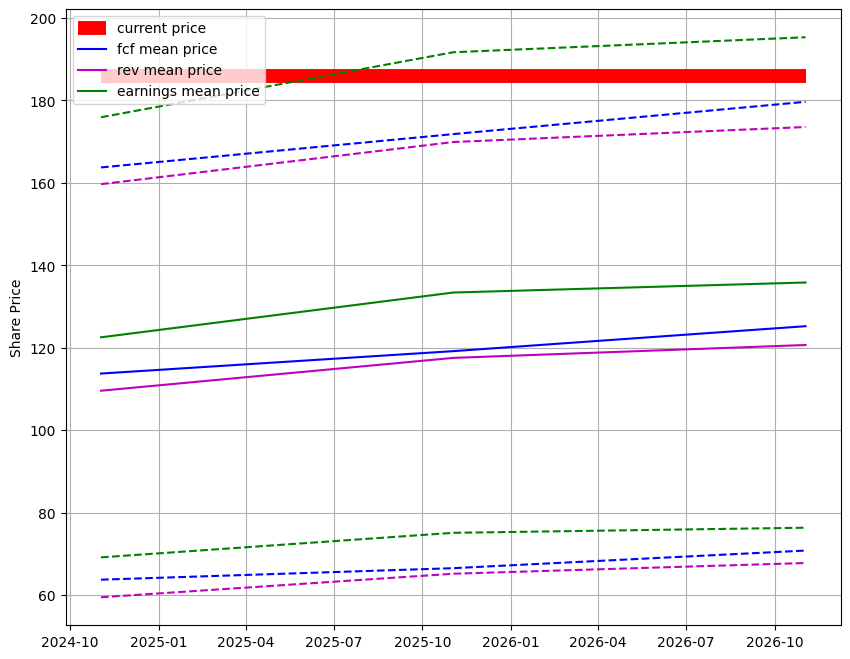

In [137]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.ylabel("Share Price")
ax.hlines(company.price_history.close[-1], year[0], year[-1], label="current price", color = "red", lw=10)
ax.plot(year, fcf_mean_price, label="fcf mean price", color="blue")
ax.plot(year, np.array(fcf_mean_price) + np.array(fcf_std_price), "--", color = "blue")
ax.plot(year, np.array(fcf_mean_price) - np.array(fcf_std_price), "--", color = "blue")
ax.plot(year, rev_mean_price, label="rev mean price", color="m")
ax.plot(year, np.array(rev_mean_price) + np.array(rev_std_price), "--", color = "m")
ax.plot(year, np.array(rev_mean_price) - np.array(rev_std_price), "--", color = "m")
ax.plot(year, earnings_mean_price, label="earnings mean price", color="green")
ax.plot(year, np.array(earnings_mean_price) + np.array(earnings_std_price), "--", color = "green")
ax.plot(year, np.array(earnings_mean_price) - np.array(earnings_std_price), "--", color = "green")
plt.grid()
plt.legend()